In [1]:
# https://www.zhihu.com/question/24533374/answer/127530955922
# https://www.kaggle.com/competitions/classify-leaves/code

import os
import pandas as pd
from PIL import Image

# 数据文件路径
data_files_dir = r"../data/kaggle-classify-leaves"
train_file_path = os.path.join(data_files_dir, 'train.csv')
test_file_path = os.path.join(data_files_dir, 'test.csv')
submission_file_path = os.path.join(data_files_dir, 'sample_submission.csv')

# 读取标注数据
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
submission_df = pd.read_csv(submission_file_path)
print(f"训练数据预览：\n{train_df.head(5)}")
print("-" * 100)
print(f"测试数据预览：\n{test_df.head(5)}")
print("-" * 100)
print(f"提交样例预览：\n{submission_df.head(5)}")
print("-" * 100)

训练数据预览：
          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera
----------------------------------------------------------------------------------------------------
测试数据预览：
              image
0  images/18353.jpg
1  images/18354.jpg
2  images/18355.jpg
3  images/18356.jpg
4  images/18357.jpg
----------------------------------------------------------------------------------------------------
提交样例预览：
              image                   label
0  images/18353.jpg      halesia_tetraptera
1  images/18354.jpg   robinia_pseudo-acacia
2  images/18355.jpg  chionanthus_virginicus
3  images/18356.jpg         ulmus_americana
4  images/18357.jpg           picea_pungens
----------------------------------------------------------------------------------------------------


In [2]:
# 将图片文件路径加入DataFrame
train_df['path'] = train_df['image'].apply(lambda x: os.path.join(data_files_dir, x))
test_df['path'] = test_df['image'].apply(lambda x: os.path.join(data_files_dir, x))


# 将图片分辨率加入DataFrame
def get_image_size(img_path: str) -> tuple:
    with Image.open(img_path) as img:
        return img.size  # (width, height)


train_df['resolution'] = train_df['path'].apply(get_image_size)
test_df['resolution'] = test_df['path'].apply(get_image_size)
print(f"完整训练数据预览：\n{train_df.head(5)}")
print("-" * 100)
print(f"完整测试数据预览：\n{test_df.head(5)}")

完整训练数据预览：
          image             label  \
0  images/0.jpg  maclura_pomifera   
1  images/1.jpg  maclura_pomifera   
2  images/2.jpg  maclura_pomifera   
3  images/3.jpg  maclura_pomifera   
4  images/4.jpg  maclura_pomifera   

                                          path  resolution  
0  ../data/kaggle-classify-leaves\images/0.jpg  (224, 224)  
1  ../data/kaggle-classify-leaves\images/1.jpg  (224, 224)  
2  ../data/kaggle-classify-leaves\images/2.jpg  (224, 224)  
3  ../data/kaggle-classify-leaves\images/3.jpg  (224, 224)  
4  ../data/kaggle-classify-leaves\images/4.jpg  (224, 224)  
----------------------------------------------------------------------------------------------------
完整测试数据预览：
              image                                             path  \
0  images/18353.jpg  ../data/kaggle-classify-leaves\images/18353.jpg   
1  images/18354.jpg  ../data/kaggle-classify-leaves\images/18354.jpg   
2  images/18355.jpg  ../data/kaggle-classify-leaves\images/18355.jpg   
3 

In [3]:
# 查看每种分辨率的数量
print(f"训练集分辨率数量：\n{train_df['resolution'].value_counts()}")
print("-" * 100)
print(f"测试集分辨率数量：\n{test_df['resolution'].value_counts()}")

训练集分辨率数量：
resolution
(224, 224)    18353
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
测试集分辨率数量：
resolution
(224, 224)    8800
Name: count, dtype: int64


训练标签预览：
[0 0 0 0 0 0 1 2 0 2]
----------------------------------------------------------------------------------------------------
唯一标签预览：
Index(['maclura_pomifera', 'ulmus_rubra', 'broussonettia_papyrifera',
       'prunus_virginiana', 'acer_rubrum', 'cryptomeria_japonica',
       'staphylea_trifolia', 'asimina_triloba', 'diospyros_virginiana',
       'tilia_cordata',
       ...
       'prunus_serrulata', 'quercus_phellos', 'cedrus_deodara',
       'celtis_occidentalis', 'sassafras_albidum', 'acer_griseum',
       'ailanthus_altissima', 'pinus_thunbergii', 'crataegus_crus-galli',
       'juniperus_virginiana'],
      dtype='object', length=176)


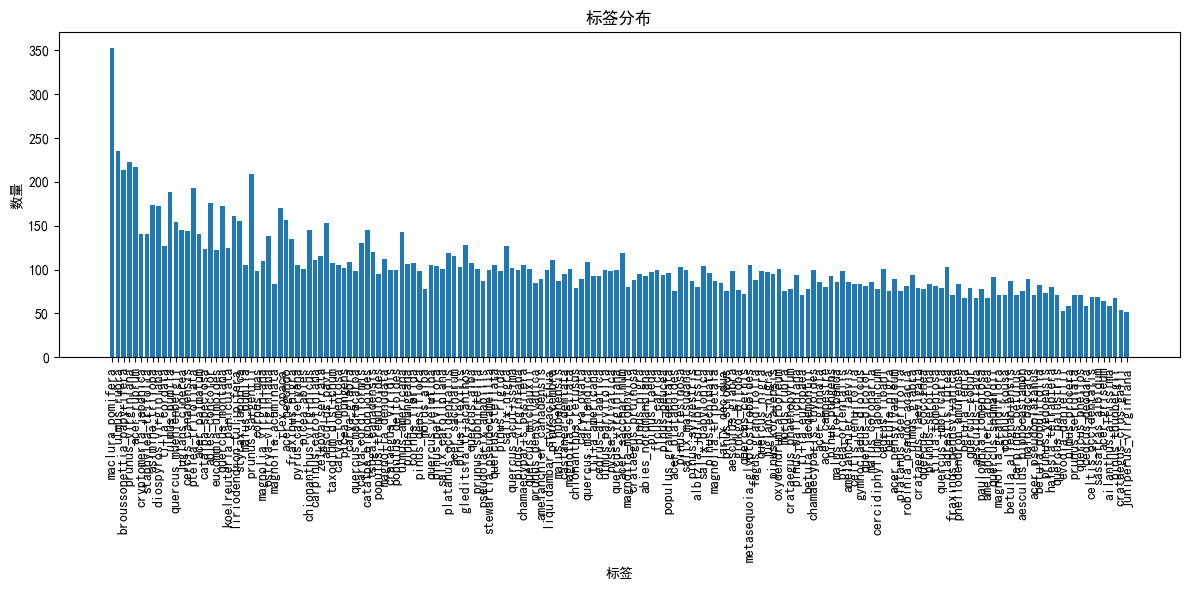

In [4]:
train_labels, unique_labels = pd.factorize(train_df['label'])
print(f"训练标签预览：\n{train_labels[:10]}")
print("-" * 100)
print(f"唯一标签预览：\n{unique_labels}")

# 可视化标签分布
import matplotlib.pyplot as plt
import numpy as np

# 临时指定字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, np.bincount(train_labels))
plt.xlabel('标签')
plt.ylabel('数量')
plt.title('标签分布')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch


class LeavesDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        """
        Args:
            df (DataFrame): 包含图片路径和标签的数据框 (train_df/test_df)
            transform (callable, optional): 对图片的变换操作
        """
        self.df = df.reset_index(drop=True)  # 重置索引，原索引丢弃
        self.transform = transform

        if 'label' in df.columns:  # 训练集
            labels, self.unique_labels = pd.factorize(df['label'])
            self.labels = torch.tensor(labels, dtype=torch.long)
            self.num_classes = len(self.unique_labels)
        else:  # 如果 'label' 列不存在则为测试集
            self.labels = None
            self.unique_labels = None
            self.relative_image_paths = df['image'].values.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns: (image, label) 如果是训练集，image 如果是测试集
        """
        img_path = self.df.loc[idx, 'path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:  # 训练集
            label = self.labels[idx]
            return image, label
        else:
            return image


tsf = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(degrees=20),  # 随机旋转
    transforms.ToTensor()
])

train_set = LeavesDataset(train_df, tsf)
test_set = LeavesDataset(test_df, tsf)

# 检查前10个样本
for i in range(10):
    X, y = train_set[i]
    print(f"样本{i}的特征维度{X.shape}, 对应的标签为{y}")


样本0的特征维度torch.Size([3, 224, 224]), 对应的标签为0
样本1的特征维度torch.Size([3, 224, 224]), 对应的标签为0
样本2的特征维度torch.Size([3, 224, 224]), 对应的标签为0
样本3的特征维度torch.Size([3, 224, 224]), 对应的标签为0
样本4的特征维度torch.Size([3, 224, 224]), 对应的标签为0
样本5的特征维度torch.Size([3, 224, 224]), 对应的标签为0
样本6的特征维度torch.Size([3, 224, 224]), 对应的标签为1
样本7的特征维度torch.Size([3, 224, 224]), 对应的标签为2
样本8的特征维度torch.Size([3, 224, 224]), 对应的标签为0
样本9的特征维度torch.Size([3, 224, 224]), 对应的标签为2


In [6]:
# 分训练集为 9/10 的训练集和 1/10 的验证集
train_ratio = 0.9
train_size = int(len(train_set) * train_ratio)
val_size = len(train_set) - train_size
print(f"训练集大小={train_size}, 验证集大小={val_size}")
print("-" * 100)

# 随机划分数据集
train_subset, val_subset = random_split(train_set, [train_size, val_size])

# 创建数据加载器
# num_workers 指定了用于加载数据的子进程数量。每个子进程负责从数据集中加载一部分数据并将其返回给主进程。
# pin_memory 是一个布尔值（True 或 False），用于指定是否使用固定内存（pinned memory）来加速数据传输。
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# 检查数据加载器
for batch_idx, (X, y) in enumerate(val_loader, start=1):
    print(f'batch {batch_idx}: X.shape={X.shape}, y.shape={y.shape}')

训练集大小=16517, 验证集大小=1836
----------------------------------------------------------------------------------------------------
batch 1: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 2: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 3: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 4: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 5: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 6: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 7: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 8: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 9: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 10: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 11: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([64])
batch 12: X.shape=torch.Size([64, 3, 224, 224]), y.shape=torch.Size([6

In [7]:
import torch.nn as nn


# 残差块
class ResNet(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        y += x  # 残差
        return self.relu(y)


b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(ResNet(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(ResNet(num_channels, num_channels))
    return blk


b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
NET = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Linear(512, train_set.num_classes))
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"运算设备：{DEVICE}")
NET.to(DEVICE)
print(f"网络名称：{NET.__class__.__name__}")
print(f"网络结构：{NET}")

运算设备：cuda
网络名称：Sequential
网络结构：Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): ResNet(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResNet(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [8]:
# 模型评估函数
def evaluate(model, dataloader: DataLoader, criterion, device='cpu'):
    model.eval()  # 关闭 dropout 和 batch norm 的训练行为
    sum_loss: float = 0.0
    sum_correct: float = 0.0
    num_samples: int = 0

    with torch.no_grad():  # 不计算梯度
        for X, y in dataloader:
            batch_size = X.size(0)  # 或 y.size(0)
            X, y = X.to(device), y.to(device)
            logits = model(X)  # shape:  (batch_size, num_classes)
            # probabilities = torch.softmax(logits, dim=1)
            # y_hat = probabilities.argmax(dim=1)  # 结果与直接对logits使用argmax相同
            y_hat = logits.argmax(dim=1)
            batch_loss = criterion(logits, y)
            sum_loss += batch_loss.item() * batch_size  # 按样本数加权
            sum_correct += (y_hat == y).sum().item()
            num_samples += batch_size

    epoch_loss = sum_loss / num_samples
    epoch_accuracy = sum_correct / num_samples * 100  # 百分比形式
    return epoch_loss, epoch_accuracy


rand_val_loss, rand_val_accuracy = evaluate(NET, val_loader, criterion=nn.CrossEntropyLoss(), device=DEVICE)
print(f"初始验证集损失：{rand_val_loss:.4f}, 初始验证集准确率：{rand_val_accuracy:.2f}%")

初始验证集损失：5.1710, 初始验证集准确率：0.60%


In [9]:
import torch.optim as optim


# 模型训练函数
def train_model(model,
                train_dl: DataLoader,
                val_dl: DataLoader,
                max_epoch: int = 10,
                learning_rate: float = 0.01,
                weight_decay: float = 1e-4,
                checkpoint_file_path: str = r'../checkpoints/kaggle_leaves.pth.tar',
                resume: bool = False,  # 是否从断点恢复训练
                device: str = 'cpu'):
    model.train()  # 设置模型为训练模式
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    best_val_accuracy: float = 0.0
    start_epoch: int = 0
    if resume and os.path.exists(checkpoint_file_path):
        checkpoint = torch.load(checkpoint_file_path,
                                map_location=device,
                                weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_accuracy = checkpoint['best_val_accuracy']
        print(f"Model loaded from epoch {start_epoch - 1} with val_accuracy: {best_val_accuracy:.2f}%")

    for epoch in range(start_epoch, max_epoch):
        model.train()  # 验证集评估evaluate步骤会将模型设置为eval模式
        sum_loss: float = 0.0
        sum_correct: float = 0.0
        num_samples: int = 0

        for X, y in train_dl:
            batch_size = X.size(0)  # 或 y.size(0)
            X, y = X.to(device), y.to(device)
            logits = model(X)
            y_hat = logits.argmax(dim=1)
            batch_loss = criterion(logits, y)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()  # 更新参数

            sum_loss += batch_loss.item() * batch_size  # 按样本数加权
            sum_correct += (y_hat == y).sum().item()
            num_samples += batch_size

        # 计算当前 epoch 训练集的平均损失和准确率
        train_epoch_loss = sum_loss / num_samples
        train_epoch_accuracy = sum_correct / num_samples * 100  # 百分比形式

        # 评估训练过的模型在验证集的表现
        val_epoch_loss, val_epoch_accuracy = evaluate(model, val_dl, criterion, device=device)

        print('=' * 100)
        print(f"Epoch {epoch + 1}/{max_epoch}: "
              f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

        # 保存检查点
        if val_epoch_accuracy > best_val_accuracy:
            best_val_accuracy = val_epoch_accuracy
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_accuracy': best_val_accuracy
            }
            torch.save(checkpoint, checkpoint_file_path, _use_new_zipfile_serialization=True)
            print(f"Checkpoint saved at epoch {epoch + 1} with Val Accuracy: {best_val_accuracy:.2f}%")


train_model(model=NET,
            train_dl=train_loader,
            val_dl=val_loader,
            max_epoch=300,
            learning_rate=0.0001,
            weight_decay=0.001,
            checkpoint_file_path=r'../checkpoints/kaggle_leaves.pth.tar',
            resume=True,
            device=DEVICE)

Model loaded from epoch 99 with val_accuracy: 93.08%
Epoch 101/300: Train Loss: 0.0777, Train Accuracy: 97.17%, Val Loss: 0.0468, Val Accuracy: 98.15%
Checkpoint saved at epoch 101 with Val Accuracy: 98.15%
Epoch 102/300: Train Loss: 0.0437, Train Accuracy: 98.31%, Val Loss: 0.3075, Val Accuracy: 90.47%
Epoch 103/300: Train Loss: 0.0354, Train Accuracy: 98.67%, Val Loss: 0.3824, Val Accuracy: 88.94%
Epoch 104/300: Train Loss: 0.0565, Train Accuracy: 98.04%, Val Loss: 1.1102, Val Accuracy: 72.55%
Epoch 105/300: Train Loss: 0.0390, Train Accuracy: 98.45%, Val Loss: 0.4880, Val Accuracy: 86.38%
Epoch 106/300: Train Loss: 0.0413, Train Accuracy: 98.41%, Val Loss: 0.8400, Val Accuracy: 81.97%
Epoch 107/300: Train Loss: 0.0817, Train Accuracy: 96.97%, Val Loss: 0.0829, Val Accuracy: 97.17%
Epoch 108/300: Train Loss: 0.0687, Train Accuracy: 97.47%, Val Loss: 0.7480, Val Accuracy: 80.88%
Epoch 109/300: Train Loss: 0.0752, Train Accuracy: 97.25%, Val Loss: 3.3608, Val Accuracy: 48.69%
Epoch 110

In [46]:
# 模型预测后生成提交文件
def create_submission(model: nn.Module,
                      test_dl: DataLoader,
                      unique_labels: list,
                      checkpoint_file_path: str = r'../checkpoints/kaggle_leaves.pth.tar',
                      submission_file_path: str = r'../output/submission_kaggle_leaves.csv'):
    """生成Kaggle提交文件"""
    if os.path.exists(checkpoint_file_path):
        checkpoint = torch.load(checkpoint_file_path,
                                map_location=DEVICE,
                                weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {checkpoint_file_path} with val_accuracy: {checkpoint['best_val_accuracy']:.2f}%")
    else:
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_file_path}")
    model.to(DEVICE)
    model.eval()
    preds = []
    with torch.no_grad():
        for X in test_dl:
            X = X.to(DEVICE)
            logits = model(X)
            probabilities = torch.softmax(logits, dim=1)
            y_hat = probabilities.argmax(dim=1)  # 获取预测类别索引
            preds.extend(y_hat.cpu().numpy())

    # 索引转换为类别名
    predicted_labels = [unique_labels[idx] for idx in preds]

    # 获取图片路径
    relative_paths = test_dl.dataset.relative_image_paths  # images/18353.jpg

    # 创建提交 DataFrame
    submission_df = pd.DataFrame({'image': relative_paths, 'label': predicted_labels})
    submission_df.to_csv(submission_file_path, index=False)  # 保存提交文件
    print(f"Submission file saved to {submission_file_path}")


TAR_LABELS = train_loader.dataset.dataset.unique_labels
create_submission(model=NET,
                  test_dl=test_loader,
                  unique_labels=TAR_LABELS,
                  checkpoint_file_path=r'../checkpoints/kaggle_leaves.pth.tar',
                  submission_file_path=r'../output/submission_kaggle_leaves.csv')

Model loaded from ../checkpoints/kaggle_leaves.pth.tar with val_accuracy: 93.08%
Submission file saved to ../output/submission_kaggle_leaves.csv


In [42]:
test_loader.dataset.relative_image_paths.tolist()[:10]

['images/18353.jpg',
 'images/18354.jpg',
 'images/18355.jpg',
 'images/18356.jpg',
 'images/18357.jpg',
 'images/18358.jpg',
 'images/18359.jpg',
 'images/18360.jpg',
 'images/18361.jpg',
 'images/18362.jpg']